In [33]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline

random_state=42
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold

np.random.seed(random_state)
random.seed(random_state)
plt.style.use('ggplot')
from autoxgb import AutoXGB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [3]:
train = train.drop('ID',axis=1)
test = test.drop('ID',axis=1)

In [4]:
# Extract day, month year and hour from the Datetime column
# day
def converte_dates(df):
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    #
    df['Datetime_day'] = df.Datetime.dt.day

    # month
    df['Datetime_month'] = df.Datetime.dt.month

    # year
    df['Datetime_year'] = df.Datetime.dt.year

    # hour
    df['Datetime_hour'] = df.Datetime.dt.hour
    
    # minute
    df['Datetime_minute'] = df.Datetime.dt.minute
    
    # day of week
    df['Datetime_dayofweek'] = df.Datetime.dt.weekday
    
    return df


train = converte_dates(train)
test = converte_dates(test)

In [5]:
train = train.drop('Datetime',axis=1)
test = test.drop('Datetime',axis=1)

In [6]:
X = train.drop('Offset_fault',axis=1)
y = train['Offset_fault']

In [7]:
pipeline = Pipeline([
    ('impute',IterativeImputer(random_state=random_state, max_iter=10, initial_strategy='mean')),
    ('scale', StandardScaler())
])

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
test = pd.DataFrame(columns=test.columns, data=pipeline.fit_transform(test))

In [8]:
num_features = X.columns.tolist()
outliers = []
for col in num_features:
    Q1 = np.percentile(train[col], 25)
    Q3 = np.percentile(train[col], 75)
    IQR = Q3-Q1

    sub_outlier = train[(train[col]<(Q1-(1.5*IQR))) | (train[col]>(Q3+(1.5*IQR)))].index
    outliers.extend(sub_outlier)

In [9]:
from collections import Counter

outlier_indices = Counter(outliers) #outliers
outliers = (k for k, v in outlier_indices.items() if v>2) #try with diffrent values

In [10]:
train.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek
0,52.58,49.52,17.4,96.0,0,3,11,2021,4,6,2
1,35.25,33.40,25.0,75.0,0,8,11,2021,18,43,0
2,19.18,23.50,24.9,75.0,0,7,11,2021,9,50,6
3,19.40,15.48,24.9,70.0,0,1,1,2022,18,55,5
4,38.30,34.77,20.9,89.0,0,5,11,2021,22,23,4


In [11]:


corr = train.corr()
corr.style.background_gradient()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek
Sensor1_PM2.5,1.000000,0.959253,-0.390342,0.345020,-0.176257,-0.065845,-0.165492,0.161995,-0.058490,-0.000501,0.005246
Sensor2_PM2.5,0.959253,1.000000,-0.363295,0.318470,-0.309739,-0.060088,-0.172149,0.172634,-0.054364,-0.000481,0.000965
Temperature,-0.390342,-0.363295,1.000000,-0.933608,0.005218,-0.012197,0.033259,-0.027746,0.374180,0.000575,0.001721
Relative_Humidity,0.345020,0.318470,-0.933608,1.000000,-0.005508,0.054963,0.090350,-0.093323,-0.389953,-0.000132,0.009902
Offset_fault,-0.176257,-0.309739,0.005218,-0.005508,1.000000,0.003973,0.006119,-0.004846,0.004706,0.000194,-0.000755
Datetime_day,-0.065845,-0.060088,-0.012197,0.054963,0.003973,1.000000,0.269636,-0.313015,-0.003369,0.000952,0.038032
Datetime_month,-0.165492,-0.172149,0.033259,0.090350,0.006119,0.269636,1.000000,-0.986940,0.006486,0.000115,0.016727
Datetime_year,0.161995,0.172634,-0.027746,-0.093323,-0.004846,-0.313015,-0.986940,1.000000,-0.008027,-0.000183,-0.024027
Datetime_hour,-0.058490,-0.054364,0.374180,-0.389953,0.004706,-0.003369,0.006486,-0.008027,1.000000,0.000474,0.003859
Datetime_minute,-0.000501,-0.000481,0.000575,-0.000132,0.000194,0.000952,0.000115,-0.000183,0.000474,1.000000,0.000479


In [12]:
train.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_minute,Datetime_dayofweek
0,52.58,49.52,17.4,96.0,0,3,11,2021,4,6,2
1,35.25,33.40,25.0,75.0,0,8,11,2021,18,43,0
2,19.18,23.50,24.9,75.0,0,7,11,2021,9,50,6
3,19.40,15.48,24.9,70.0,0,1,1,2022,18,55,5
4,38.30,34.77,20.9,89.0,0,5,11,2021,22,23,4


<AxesSubplot:>

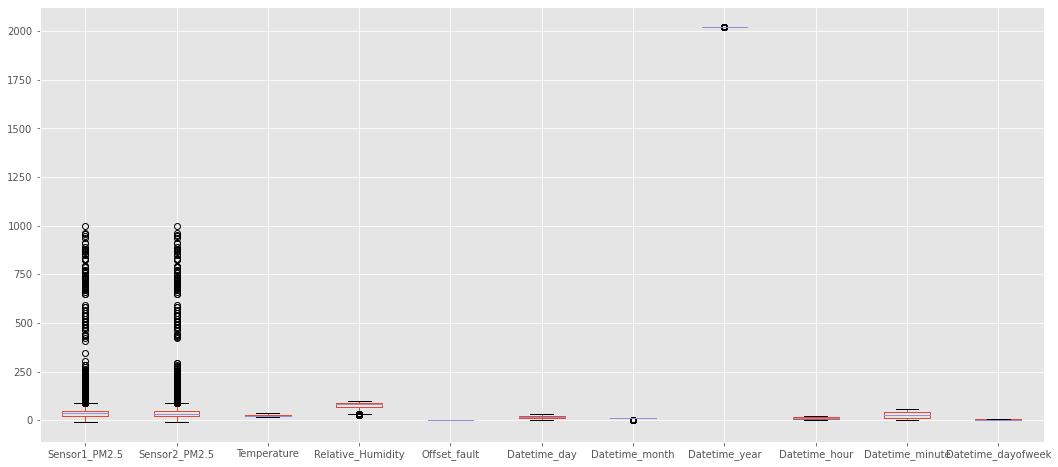

In [13]:
train.boxplot(figsize=(18,8))

In [14]:


Q1 = train.drop(['Offset_fault'], axis=1).quantile(0.25)
Q3 = train.drop(['Offset_fault'], axis=1).quantile(0.75)

IQR = Q3 - Q1


print(IQR)

Sensor1_PM2.5         26.99
Sensor2_PM2.5         28.05
Temperature            5.90
Relative_Humidity     23.00
Datetime_day          14.00
Datetime_month         2.00
Datetime_year          0.00
Datetime_hour         12.00
Datetime_minute       30.00
Datetime_dayofweek     4.00
dtype: float64


In [15]:
train.shape

(297177, 11)

In [16]:
train = train[~((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).any(axis=1)]

/tmp/ipykernel_57217/2142018268.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train = train[~((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).any(axis=1)]


In [17]:
train.shape

(224729, 11)

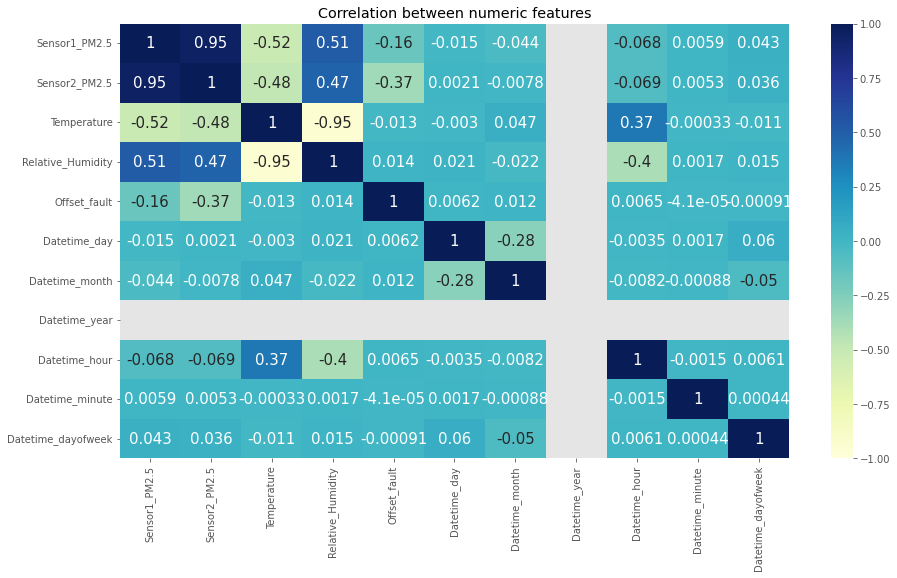

In [20]:
plt.figure(figsize=(15, 8))
sns.heatmap(train.corr(), cmap='YlGnBu', vmax=1.0, vmin=-1.0, annot = True, annot_kws={"size": 15})
plt.title('Correlation between numeric features')
plt.show()

In [22]:
test.shape,train.shape

((127361, 10), (224729, 11))

In [23]:
train.columns.to_list()

['Sensor1_PM2.5',
 'Sensor2_PM2.5',
 'Temperature',
 'Relative_Humidity',
 'Offset_fault',
 'Datetime_day',
 'Datetime_month',
 'Datetime_year',
 'Datetime_hour',
 'Datetime_minute',
 'Datetime_dayofweek']

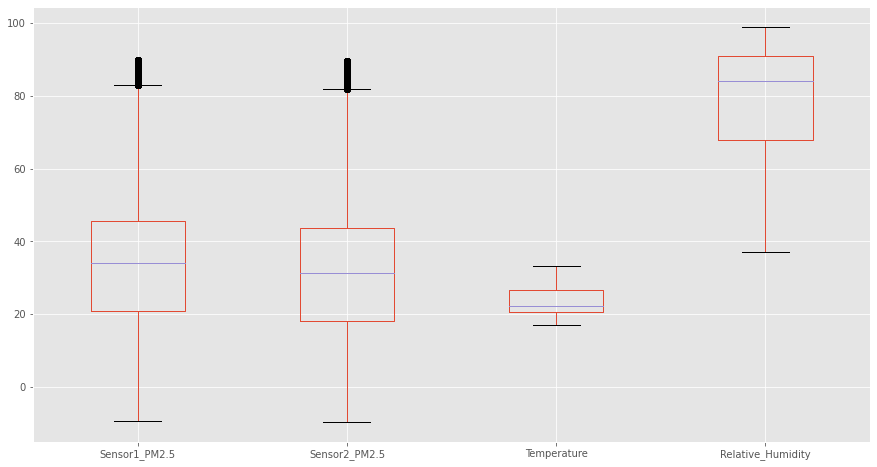

In [25]:
plt.rcParams['figure.figsize']=(15,8)
train.boxplot(column=['Sensor1_PM2.5',
 'Sensor2_PM2.5',
 'Temperature',
 'Relative_Humidity'])
plt.show()

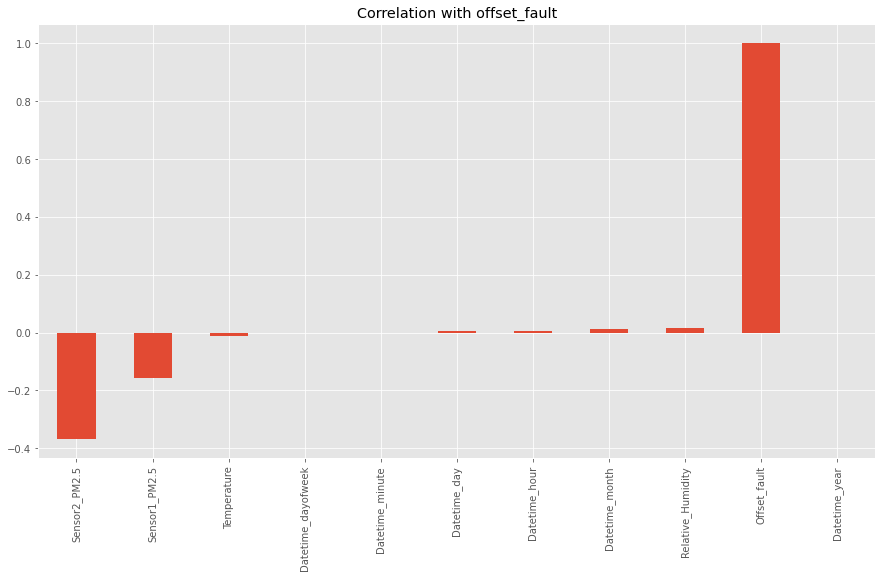

In [32]:
plt.title("Correlation with offset_fault")
train.corr()['Offset_fault'].sort_values().plot(kind='bar')
plt.show()

In [26]:
X = train.drop(['Offset_fault'],axis=1)
y = train['Offset_fault']

In [38]:
from sklearn.model_selection import cross_val_score

k = 10
kf = KFold(n_splits=k, shuffle=True)
model = LGBMClassifier()
 
result = cross_val_score(model , X, y, cv = kf)
 
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.953971235955042


In [39]:
# #Implementing cross validation
 
# k = 5
# kf = KFold(n_splits=k, shuffle=True)
# model = LGBMClassifier()
 
# acc_score = []
 
# for train_index , test_index in kf.split(X,y):
#     X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
#     y_train , y_test = y[train_index] , y[test_index]
     
#     model.fit(X_train,y_train)
#     pred_values = model.predict(X_test)
     
#     acc = accuracy_score(pred_values , y_test)
#     acc_score.append(acc)
     
# avg_acc_score = sum(acc_score)/k
 
# print('accuracy of each fold - {}'.format(acc_score))
# print('Avg accuracy : {}'.format(avg_acc_score))

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=random_state, test_size=0.02)

In [43]:
model = LGBMClassifier()
model.fit(X_train,y_train)
pred = model.predict(X_test)

print(f"Training Accuracy: {model.score(X_train, y_train):0.3f}")
print(f"Test Accuracy: {model.score(X_test, y_test):0.3f}")

Training Accuracy: 0.956
Test Accuracy: 0.953


In [44]:
pred_model = model.predict(test)
sub = pd.DataFrame({'ID':ss.ID,'Offset_fault':pred_model})
sub.to_csv('model.csv',index=False)
